   Unnamed: 0     TV  Radio  Newspaper  Sales
0           1  230.1   37.8       69.2   22.1
1           2   44.5   39.3       45.1   10.4
2           3   17.2   45.9       69.3    9.3
3           4  151.5   41.3       58.5   18.5
4           5  180.8   10.8       58.4   12.9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
LSTM MAE: 0.461, RMSE: 0.631, R²: 0.987


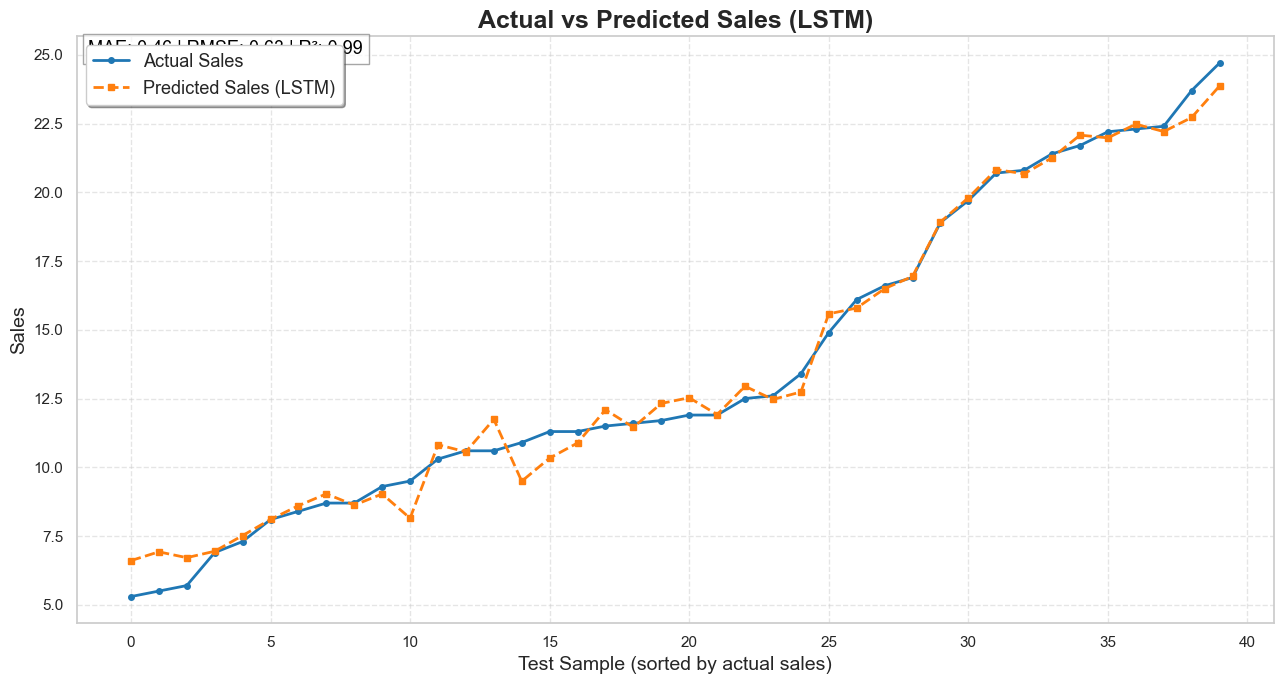

In [2]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import seaborn as sns

# 2. Load Data
df = pd.read_csv(r"C:\Users\bhavya gupta\Downloads\archive (2)\Advertising.csv")
print(df.head())

# 3. Features and Target
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales'].values

# 4. Polynomial Features (optional, can comment out if not needed)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 5. Feature Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_poly)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# 7. Prepare data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 8. Build and Train LSTM Model (fixed warning with Input layer)
model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train, epochs=40, batch_size=16, verbose=0)

# 9. Predict and Inverse Transform
y_pred_scaled = model.predict(X_test_lstm).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 10. Evaluation
mae = mean_absolute_error(y_test_inv, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
r2 = r2_score(y_test_inv, y_pred)
print(f"LSTM MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 11. Attractive Plot: Actual vs Predicted
plt.figure(figsize=(13,7))
sns.set(style="whitegrid")
sorted_idx = np.argsort(y_test_inv)
plt.plot(y_test_inv[sorted_idx], label='Actual Sales', color='#1f77b4', linewidth=2, marker='o', markersize=4)
plt.plot(y_pred[sorted_idx], label='Predicted Sales (LSTM)', color='#ff7f0e', linewidth=2, marker='s', markersize=4, linestyle='--')
plt.title('Actual vs Predicted Sales (LSTM)', fontsize=18, fontweight='bold')
plt.xlabel('Test Sample (sorted by actual sales)', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend(fontsize=13, loc='upper left', frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.text(0.01, 0.97, f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}",
         transform=plt.gca().transAxes, fontsize=13, color='black', 
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.show()
